<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: MIRI LRS Slit

## Spec2: Extract1d()
<span style="color:red"> **Instruments Affected**</span>: MIRI

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Get Documentaion String for Markdown Blocks](#markdown_from_docs) <br> [Loading Data](#data_ID) <br> [Run JWST Pipeline](#pipeline_ID) <br> [Create Figure or Print Output](#residual_ID) <br> [About This Notebook](#about_ID) <br>

</div>

<a id="imports_ID"></a>
# Imports
List the library imports and why they are relevant to this notebook.

* os, glob for general  OS operations
* numpy
* astropy.io for opening fits files
* inspect to get the docstring of our objects.
* IPython.display for printing markdown output
* jwst.datamodels for building model for JWST Pipeline
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot to generate plot
* json for editing json files
* crds for retrieving reference files as needed



[Top of Page](#title_ID)

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
data_dir = TemporaryDirectory()
os.chdir(data_dir.name)

In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /grp/crds/cache


In [3]:
import numpy as np
from numpy.testing import assert_allclose
import os
from glob import glob
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import astropy.io.fits as fits
import astropy.units as u
import jwst.datamodels as datamodels
from jwst.datamodels import RampModel, ImageModel
from jwst.pipeline import Detector1Pipeline, Spec2Pipeline
from jwst.extract_1d import Extract1dStep
from gwcs.wcstools import grid_from_bounding_box
from jwst.associations.asn_from_list import asn_from_list
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase


import json
import crds

from ci_watson.artifactory_helpers import get_bigdata

%matplotlib inline

<a id="intro_ID"></a>
# Introduction


In this notebook we will test the **extract1d()** step of Spec2Pipeline() for **LRS slit** observations.

Step description: https://jwst-pipeline.readthedocs.io/en/stable/jwst/extract_1d/index.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/extract_1d

### Short description of the algorithm

The extract1d() step does the following for POINT source observations:

* the code searches for the ROW that is the centre of the bounding box y-range
* using the WCS information attached to the data in assign_wcs() it will determine the COLUMN location of the target
* it computes the difference between this location and the centre of the bounding box x-range
* BY DEFAULT the exraction aperture will be centred on the target location, and the flux in the aperture will be summed row by row. The default extraction width is a constant value of 11 PIXELS.

In **Test 1** below, we load the json file that contains the default parameters, and override these to perform extraction over the full bounding box width for a single exposure. This tests the basic arithmetic of the extraction.

In **Test 2**, we use the pair of nodded exposures and pass these in an association to the Spec2Pipeline, allowing extract1d() to perform the default extraction on a nodded pair. This is a very typical LRS science use case.

[Top of Page](#title_ID)

<a id="data_ID"></a>
# Loading Data

We are using here a simulated LRS slit observation, generated with MIRISim v2.3.0 (as of Dec 2020). It is a simple along-slit-nodded observation of a point source (the input was modelled on the flux calibrator BD+60). LRS slit observations cover the full array. 


[Top of Page](#title_ID)

In [4]:
Slitfile1 = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_spec2',
                                    'spec2_miri_test',
                                    'miri_lrs_slit_pt_nod1_v2.3.fits')
 
Slitfile2 = get_bigdata('jwst_validation_notebooks',
                                     'validation_data',
                                     'calwebb_spec2',
                                    'spec2_miri_test',
                                    'miri_lrs_slit_pt_nod2_v2.3.fits')

files = [Slitfile1, Slitfile2]

<a id="pipeline_ID"></a>
# Run JWST Pipeline

First we run the data through the Detector1() pipeline to convert the raw counts into slopes. This should use the calwebb_detector1.cfg file. The output of this stage will then be run through the Spec2Pipeline. Extract_1d is the final step of this pipeline stage, so we will just run through the whole pipeline.

[Top of Page](#title_ID)

### Detector1Pipeline

In [5]:
det1 = []

# Run pipeline on both files
for ff in files:
    d1 = Detector1Pipeline.call(ff, save_results=True)
    det1.append(d1)

print(det1)

2022-10-04 22:43:00,003 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-10-04 22:43:00,025 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-04 22:43:00,026 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-04 22:43:00,027 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-04 22:43:00,028 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-04 22:43:00,029 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-04 22:43:00,031 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-04 22:43:00,032 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-04 22:43:00,033 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-04 22:43:00,034 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-04 22:43:00,035 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-04 22:43:00,036 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-04 22:43:00,037 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-04 22:43:00,038 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-04 22:43:00,039 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-04 22:43:00,041 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-04 22:43:00,042 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-04 22:43:00,043 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-04 22:43:00,148 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9/miri_lrs_slit_pt_nod1_v2.3.fits',).


2022-10-04 22:43:00,158 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-04 22:43:00,343 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod1_v2.3.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-04 22:43:00,359 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-10-04 22:43:00,361 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-10-04 22:43:00,363 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-10-04 22:43:00,365 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-10-04 22:43:00,366 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-04 22:43:00,367 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits'.


2022-10-04 22:43:00,368 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-10-04 22:43:00,369 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-10-04 22:43:00,370 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-10-04 22:43:00,372 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-10-04 22:43:00,373 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-04 22:43:00,373 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-04 22:43:00,374 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-04 22:43:00,374 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-04 22:43:00,666 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-10-04 22:43:00,667 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9'}


2022-10-04 22:43:00,782 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-04 22:43:00,783 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-04 22:43:00,786 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-04 22:43:00,894 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-10-04 22:43:00,895 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9'}


2022-10-04 22:43:00,917 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-10-04 22:43:01,201 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-04 22:43:01,312 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-10-04 22:43:01,313 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9', 'n_pix_grow_sat': 1}


2022-10-04 22:43:01,335 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-10-04 22:43:02,284 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-10-04 22:43:02,302 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-04 22:43:02,312 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-04 22:43:02,438 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-10-04 22:43:02,439 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9'}


2022-10-04 22:43:02,440 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-04 22:43:02,443 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-04 22:43:02,540 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-10-04 22:43:02,542 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9'}


2022-10-04 22:43:02,663 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-04 22:43:02,771 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-10-04 22:43:02,773 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9'}


2022-10-04 22:43:02,892 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-04 22:43:03,001 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-10-04 22:43:03,003 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9'}


2022-10-04 22:43:03,024 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-10-04 22:43:05,061 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-04 22:43:05,280 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-10-04 22:43:05,282 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9'}


2022-10-04 22:43:05,308 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-10-04 22:43:06,602 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-04 22:43:06,843 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-10-04 22:43:06,846 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9', 'type': 'baseline'}


2022-10-04 22:43:06,874 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-10-04 22:43:07,082 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-04 22:43:07,304 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-10-04 22:43:07,306 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9', 'dark_output': None}


2022-10-04 22:43:07,331 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-10-04 22:43:25,520 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=10, nframes=1, groupgap=0


2022-10-04 22:43:25,522 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-10-04 22:43:26,502 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-04 22:43:26,751 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-10-04 22:43:26,753 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-04 22:43:26,883 - stpipe.Detector1Pipeline.refpix - INFO - MIRI full frame data


2022-10-04 22:43:26,884 - stpipe.Detector1Pipeline.refpix - INFO - The following parameter is valid for this mode:


2022-10-04 22:43:26,884 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2022-10-04 22:43:26,885 - stpipe.Detector1Pipeline.refpix - INFO - The following parameters are not applicable and are ignored:


2022-10-04 22:43:26,885 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = False


2022-10-04 22:43:26,885 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = False


2022-10-04 22:43:26,886 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = False


2022-10-04 22:43:26,886 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = False


2022-10-04 22:43:26,887 - stpipe.Detector1Pipeline.refpix - INFO - Subtracting initial read from each integration


2022-10-04 22:43:27,219 - stpipe.Detector1Pipeline.refpix - INFO - Adding initial read back in


2022-10-04 22:43:27,283 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-04 22:43:27,501 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-10-04 22:43:27,504 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-04 22:43:27,514 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-04 22:43:27,529 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-10-04 22:43:27,586 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits


2022-10-04 22:43:27,872 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-04 22:43:27,932 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-04 22:43:29,150 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28384 pixels with at least one CR from five or more groups.


2022-10-04 22:43:29,152 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 22:43:29,153 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 22:43:32,931 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-04 22:43:34,249 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12669 pixels with at least one CR from five or more groups.


2022-10-04 22:43:34,250 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 22:43:34,250 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 22:43:35,667 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 7.79328 sec


2022-10-04 22:43:35,674 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 8.160036


2022-10-04 22:43:35,682 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-04 22:43:35,949 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-10-04 22:43:35,951 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-04 22:43:35,989 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits


2022-10-04 22:43:35,990 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-10-04 22:43:36,047 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-04 22:43:36,048 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-04 22:43:36,174 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-04 22:43:36,176 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-04 22:43:49,166 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-10-04 22:43:49,167 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2


2022-10-04 22:43:49,264 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-04 22:43:49,408 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-10-04 22:43:49,409 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9'}


2022-10-04 22:43:49,449 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 22:43:49,449 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 22:43:49,454 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 22:43:49,542 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 1024, 1032) from miri_lrs_slit_pt_nod1_v2.3.fits>,).


2022-10-04 22:43:49,543 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9'}


2022-10-04 22:43:49,590 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 22:43:49,591 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 22:43:49,595 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 22:43:49,689 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_rateints.fits


2022-10-04 22:43:49,689 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-04 22:43:49,690 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 22:43:49,753 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod1_v2.3_rate.fits


2022-10-04 22:43:49,754 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-10-04 22:43:49,939 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-detector1pipeline_0001.asdf


2022-10-04 22:43:49,956 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-10-04 22:43:49,958 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-10-04 22:43:49,959 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-10-04 22:43:49,960 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-10-04 22:43:49,961 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-10-04 22:43:49,962 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-10-04 22:43:49,963 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-10-04 22:43:49,963 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-10-04 22:43:49,964 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-10-04 22:43:49,966 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-10-04 22:43:49,967 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-10-04 22:43:49,968 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-10-04 22:43:49,969 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-10-04 22:43:49,970 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-10-04 22:43:49,971 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-10-04 22:43:49,972 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-10-04 22:43:49,974 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-10-04 22:43:50,087 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9/miri_lrs_slit_pt_nod2_v2.3.fits',).


2022-10-04 22:43:50,096 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'saturation': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-10-04 22:43:50,262 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod2_v2.3.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-10-04 22:43:50,269 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-10-04 22:43:50,271 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-10-04 22:43:50,272 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-10-04 22:43:50,274 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-10-04 22:43:50,275 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-10-04 22:43:50,276 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits'.


2022-10-04 22:43:50,277 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.


2022-10-04 22:43:50,277 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-10-04 22:43:50,279 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-10-04 22:43:50,280 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-10-04 22:43:50,282 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-10-04 22:43:50,282 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-10-04 22:43:50,282 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-10-04 22:43:50,283 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-10-04 22:43:50,566 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-10-04 22:43:50,567 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9'}


2022-10-04 22:43:50,679 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-10-04 22:43:50,679 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-10-04 22:43:50,682 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-10-04 22:43:50,779 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-10-04 22:43:50,780 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9'}


2022-10-04 22:43:50,802 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-10-04 22:43:51,054 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-10-04 22:43:51,153 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-10-04 22:43:51,155 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9', 'n_pix_grow_sat': 1}


2022-10-04 22:43:51,176 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-10-04 22:43:52,026 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 saturated pixels


2022-10-04 22:43:52,038 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-10-04 22:43:52,047 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-10-04 22:43:52,144 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-10-04 22:43:52,146 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9'}


2022-10-04 22:43:52,147 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2022-10-04 22:43:52,150 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-10-04 22:43:52,253 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-10-04 22:43:52,254 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9'}


2022-10-04 22:43:52,377 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-10-04 22:43:52,481 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-10-04 22:43:52,482 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9'}


2022-10-04 22:43:52,588 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-10-04 22:43:52,683 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-10-04 22:43:52,684 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9'}


2022-10-04 22:43:52,705 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-10-04 22:43:53,069 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-10-04 22:43:53,169 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-10-04 22:43:53,170 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9'}


2022-10-04 22:43:53,192 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-10-04 22:43:53,583 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-10-04 22:43:53,681 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-10-04 22:43:53,682 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9', 'type': 'baseline'}


2022-10-04 22:43:53,704 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-10-04 22:43:53,861 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-10-04 22:43:53,965 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-10-04 22:43:53,966 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9', 'dark_output': None}


2022-10-04 22:43:53,987 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-10-04 22:43:55,666 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=10, nframes=1, groupgap=0


2022-10-04 22:43:55,667 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-10-04 22:43:56,396 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-10-04 22:43:56,502 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-10-04 22:43:56,504 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-10-04 22:43:56,620 - stpipe.Detector1Pipeline.refpix - INFO - MIRI full frame data


2022-10-04 22:43:56,621 - stpipe.Detector1Pipeline.refpix - INFO - The following parameter is valid for this mode:


2022-10-04 22:43:56,622 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True


2022-10-04 22:43:56,622 - stpipe.Detector1Pipeline.refpix - INFO - The following parameters are not applicable and are ignored:


2022-10-04 22:43:56,622 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = False


2022-10-04 22:43:56,623 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = False


2022-10-04 22:43:56,623 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = False


2022-10-04 22:43:56,623 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = False


2022-10-04 22:43:56,626 - stpipe.Detector1Pipeline.refpix - INFO - Subtracting initial read from each integration


2022-10-04 22:43:56,876 - stpipe.Detector1Pipeline.refpix - INFO - Adding initial read back in


2022-10-04 22:43:56,928 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-10-04 22:43:57,026 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-10-04 22:43:57,027 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9', 'rejection_threshold': 4.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0, 'after_jump_flag_dn1': 0.0, 'after_jump_flag_time1': 0.0, 'after_jump_flag_dn2': 0.0, 'after_jump_flag_time2': 0.0}


2022-10-04 22:43:57,037 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2022-10-04 22:43:57,050 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-10-04 22:43:57,087 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits


2022-10-04 22:43:57,272 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-10-04 22:43:57,313 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-10-04 22:43:58,191 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 28153 pixels with at least one CR from five or more groups.


2022-10-04 22:43:58,192 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 22:43:58,192 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 22:44:01,946 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-10-04 22:44:02,854 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 12958 pixels with at least one CR from five or more groups.


2022-10-04 22:44:02,855 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-10-04 22:44:02,855 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-10-04 22:44:04,269 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 6.99536 sec


2022-10-04 22:44:04,274 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 7.237055


2022-10-04 22:44:04,280 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-10-04 22:44:04,407 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 10, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-10-04 22:44:04,409 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-10-04 22:44:04,446 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /grp/crds/cache/references/jwst/jwst_miri_readnoise_0057.fits


2022-10-04 22:44:04,446 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-10-04 22:44:04,497 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-10-04 22:44:04,497 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-10-04 22:44:04,583 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-10-04 22:44:04,584 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-10-04 22:44:16,654 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 8


2022-10-04 22:44:16,656 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 2


2022-10-04 22:44:16,752 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-10-04 22:44:16,980 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-10-04 22:44:16,982 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9'}


2022-10-04 22:44:17,025 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 22:44:17,026 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 22:44:17,031 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 22:44:17,252 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 1024, 1032) from miri_lrs_slit_pt_nod2_v2.3.fits>,).


2022-10-04 22:44:17,254 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9'}


2022-10-04 22:44:17,297 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-10-04 22:44:17,298 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-10-04 22:44:17,303 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-10-04 22:44:17,405 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_rateints.fits


2022-10-04 22:44:17,406 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-10-04 22:44:17,406 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 22:44:17,476 - stpipe.Detector1Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod2_v2.3_rate.fits


2022-10-04 22:44:17,477 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


[<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>, <ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>]


### Spec2Pipeline

Next we go ahead to the Spec2 pipeline. At this stage we perform 2 tests:

1. run the Spec2 pipeline on one single exposure, extracting over the full bounding box width. we compare this with the manual extraction over the same aperture. this tests whether the pipeline is performing the correct arithmetic in the extraction procedure.
2. run the Spec2 pipeline on the nodded set of exposures. this mimics more closely how the pipeline will be run in automated way during routine operations. this will test whether the pipeline is finding the source positions, and is able to extract both nodded observations in the same way.

The initial steps will be the same for both tests and will be run on both initially. Spectral extraction is performed on the output file of the 2D resampled images (\_s2d.fits)

First we run the Spec2Pipeline() **skipping** the extract1d() step.


In [6]:
spec2 = []
for dd in det1:
    s2 = Spec2Pipeline.call(dd.meta.filename,save_results=True, steps={"extract_1d": {"skip": True}})
    spec2.append(s2)

2022-10-04 22:44:17,547 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-spec2pipeline_0003.asdf


2022-10-04 22:44:17,578 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 22:44:17,580 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 22:44:17,581 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 22:44:17,582 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 22:44:17,583 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 22:44:17,584 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 22:44:17,587 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 22:44:17,588 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 22:44:17,590 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 22:44:17,591 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 22:44:17,593 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 22:44:17,594 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 22:44:17,595 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 22:44:17,597 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 22:44:17,598 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 22:44:17,600 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 22:44:17,601 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 22:44:17,602 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 22:44:17,603 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 22:44:17,604 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 22:44:17,606 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 22:44:17,607 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 22:44:17,609 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 22:44:17,813 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('miri_lrs_slit_pt_nod1_v2.3_rate.fits',).


2022-10-04 22:44:17,828 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 22:44:17,865 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod1_v2.3_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-04 22:44:17,881 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 22:44:17,881 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 22:44:17,882 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 22:44:17,882 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 22:44:17,883 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.


2022-10-04 22:44:17,883 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 22:44:17,883 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 22:44:17,884 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-10-04 22:44:17,887 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 22:44:17,888 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 22:44:17,888 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 22:44:17,889 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0736.fits'.


2022-10-04 22:44:17,891 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 22:44:17,891 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 22:44:17,891 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2022-10-04 22:44:17,892 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 22:44:17,892 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 22:44:17,892 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 22:44:17,893 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2022-10-04 22:44:17,893 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 22:44:17,894 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 22:44:17,894 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 22:44:17,894 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/grp/crds/cache/references/jwst/jwst_miri_pathloss_0001.fits'.


2022-10-04 22:44:17,896 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0072.fits'.


2022-10-04 22:44:17,897 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-10-04 22:44:17,898 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 22:44:17,898 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0003.fits'.


2022-10-04 22:44:17,899 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 22:44:17,900 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-10-04 22:44:17,900 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 22:44:17,901 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 22:44:17,902 - stpipe.Spec2Pipeline - INFO - Processing product miri_lrs_slit_pt_nod1_v2.3


2022-10-04 22:44:17,903 - stpipe.Spec2Pipeline - INFO - Working on input miri_lrs_slit_pt_nod1_v2.3_rate.fits ...


2022-10-04 22:44:18,133 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-10-04 22:44:18,135 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 22:44:18,424 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_lrs-fixedslit pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0003.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 22:44:18,532 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.000379612 -0.000035778 0.000379612 0.000080412 359.999082432 0.000080412 359.999082432 -0.000035778


2022-10-04 22:44:18,533 - stpipe.Spec2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.000379612 -0.000035778 0.000379612 0.000080412 359.999082432 0.000080412 359.999082432 -0.000035778


2022-10-04 22:44:18,534 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 22:44:18,548 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 22:44:18,756 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>, []).


2022-10-04 22:44:18,757 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 22:44:18,758 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-04 22:44:18,761 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 22:44:18,957 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>, []).


2022-10-04 22:44:18,959 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 22:44:18,959 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 22:44:18,962 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 22:44:19,164 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-10-04 22:44:19,166 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 22:44:19,166 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 22:44:19,169 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 22:44:19,366 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-10-04 22:44:19,368 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 22:44:19,376 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_LRS-FIXEDSLIT


2022-10-04 22:44:19,376 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 22:44:19,377 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 22:44:19,377 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = POINT


2022-10-04 22:44:19,381 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 22:44:19,572 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-10-04 22:44:19,574 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 22:44:19,700 - stpipe.Spec2Pipeline.flat_field - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stdatamodels/validate.py:38: ValidationWarning: While validating meta.exposure.type the following error occurred:
'MIR_FLAT-IMAGE' is not one of ['FGS_DARK', 'FGS_FOCUS', 'FGS_IMAGE', 'FGS_INTFLAT', 'FGS_SKYFLAT', 'FGS_ACQ1', 'FGS_ACQ2', 'FGS_FINEGUIDE', 'FGS_ID-IMAGE', 'FGS_ID-STACK', 'FGS_TRACK', 'MIR_4QPM', 'MIR_CORONCAL', 'MIR_DARKALL', 'MIR_DARKIMG', 'MIR_DARKMRS', 'MIR_FLATIMAGE', 'MIR_FLATIMAGE-EXT', 'MIR_FLATMRS', 'MIR_FLATMRS-EXT', 'MIR_IMAGE', 'MIR_LRS-FIXEDSLIT', 'MIR_LRS-SLITLESS', 'MIR_LYOT', 'MIR_MRS', 'MIR_TACONFIRM', 'MIR_TACQ', 'NIS_AMI', 'NIS_DARK', 'NIS_EXTCAL', 'NIS_FOCUS', 'NIS_IMAGE', 'NIS_LAMP', 'NIS_SOSS', 'NIS_TACQ', 'NIS_TACONFIRM', 'NIS_WFSS', 'NRC_CORON', 'NRC_DARK', 'NRC_FLAT', 'NRC_FOCUS', 'NRC_GRISM', 'NRC_IMAGE', 'NRC_WFSS', 'NRC_LED

2022-10-04 22:44:20,092 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 22:44:20,094 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 22:44:20,094 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 22:44:20,124 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 22:44:20,341 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 22:44:20,563 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-10-04 22:44:20,565 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 22:44:20,566 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 22:44:20,569 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 22:44:20,784 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-10-04 22:44:20,786 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 22:44:20,787 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2022-10-04 22:44:20,790 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 22:44:21,000 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-10-04 22:44:21,001 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 22:44:21,019 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /grp/crds/cache/references/jwst/jwst_miri_pathloss_0001.fits


2022-10-04 22:44:21,090 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is MIR_LRS-FIXEDSLIT


2022-10-04 22:44:21,337 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 22:44:21,551 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-10-04 22:44:21,552 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 22:44:21,553 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 22:44:21,556 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 22:44:21,754 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-10-04 22:44:21,756 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 22:44:21,781 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0072.fits


2022-10-04 22:44:21,782 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 22:44:21,898 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 22:44:21,899 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-10-04 22:44:21,900 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_LRS-FIXEDSLIT


2022-10-04 22:44:21,900 - stpipe.Spec2Pipeline.photom - INFO -  filter: P750L


2022-10-04 22:44:21,939 - stpipe.Spec2Pipeline.photom - INFO -  subarray: FULL


2022-10-04 22:44:21,940 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 60.567


2022-10-04 22:44:22,011 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 22:44:22,238 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2_cal.fits>,).


2022-10-04 22:44:22,240 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}


2022-10-04 22:44:22,490 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-10-04 22:44:22,626 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter kernal: square


2022-10-04 22:44:22,627 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter pixfrac: 1.0


2022-10-04 22:44:22,627 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter fillval: INDEF


2022-10-04 22:44:22,628 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter weight_type: ivm


2022-10-04 22:44:22,672 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data


2022-10-04 22:44:23,614 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)


2022-10-04 22:44:23,633 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise


2022-10-04 22:44:24,526 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)


2022-10-04 22:44:24,533 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson


2022-10-04 22:44:25,245 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)


2022-10-04 22:44:25,251 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat


2022-10-04 22:44:25,957 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)


2022-10-04 22:44:25,981 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  359.999103211 -0.000033657 0.000420119 -0.000033657 0.000420119 0.000075807 359.999103211 0.000075807


2022-10-04 22:44:26,089 - stpipe.Spec2Pipeline.resample_spec - INFO - Saved model in miri_lrs_slit_pt_nod1_v2_s2d.fits


2022-10-04 22:44:26,090 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done


2022-10-04 22:44:26,227 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(387, 44) from miri_lrs_slit_pt_nod1_v2_s2d.fits>,).


2022-10-04 22:44:26,229 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 22:44:26,229 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-04 22:44:26,232 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 22:44:26,232 - stpipe.Spec2Pipeline - INFO - Finished processing product miri_lrs_slit_pt_nod1_v2.3


2022-10-04 22:44:26,233 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 22:44:26,234 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 22:44:26,433 - stpipe.Spec2Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod1_v2_cal.fits


2022-10-04 22:44:26,434 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2022-10-04 22:44:26,488 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-spec2pipeline_0003.asdf


2022-10-04 22:44:26,509 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 22:44:26,511 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 22:44:26,512 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 22:44:26,513 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 22:44:26,514 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 22:44:26,515 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 22:44:26,520 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 22:44:26,521 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 22:44:26,522 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 22:44:26,523 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 22:44:26,524 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 22:44:26,525 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 22:44:26,526 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 22:44:26,527 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 22:44:26,528 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 22:44:26,529 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 22:44:26,530 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 22:44:26,531 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 22:44:26,532 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 22:44:26,533 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 22:44:26,535 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 22:44:26,536 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 22:44:26,538 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 22:44:26,655 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('miri_lrs_slit_pt_nod2_v2.3_rate.fits',).


2022-10-04 22:44:26,669 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 22:44:26,703 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod2_v2.3_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2022-10-04 22:44:26,708 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 22:44:26,709 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 22:44:26,709 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 22:44:26,710 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 22:44:26,710 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.


2022-10-04 22:44:26,711 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 22:44:26,711 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 22:44:26,711 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-10-04 22:44:26,713 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 22:44:26,714 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 22:44:26,715 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 22:44:26,715 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0736.fits'.


2022-10-04 22:44:26,717 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 22:44:26,717 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 22:44:26,717 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2022-10-04 22:44:26,718 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 22:44:26,718 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 22:44:26,718 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 22:44:26,718 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2022-10-04 22:44:26,719 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 22:44:26,719 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 22:44:26,719 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 22:44:26,720 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/grp/crds/cache/references/jwst/jwst_miri_pathloss_0001.fits'.


2022-10-04 22:44:26,721 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0072.fits'.


2022-10-04 22:44:26,723 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-10-04 22:44:26,723 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 22:44:26,724 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0003.fits'.


2022-10-04 22:44:26,725 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 22:44:26,725 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-10-04 22:44:26,726 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 22:44:26,726 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 22:44:26,727 - stpipe.Spec2Pipeline - INFO - Processing product miri_lrs_slit_pt_nod2_v2.3


2022-10-04 22:44:26,727 - stpipe.Spec2Pipeline - INFO - Working on input miri_lrs_slit_pt_nod2_v2.3_rate.fits ...


2022-10-04 22:44:26,870 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-10-04 22:44:26,872 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 22:44:27,154 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_lrs-fixedslit pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0003.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 22:44:27,257 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.000903013 -0.000079284 0.000903013 0.000036907 359.999605833 0.000036907 359.999605833 -0.000079284


2022-10-04 22:44:27,258 - stpipe.Spec2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.000903013 -0.000079284 0.000903013 0.000036907 359.999605833 0.000036907 359.999605833 -0.000079284


2022-10-04 22:44:27,258 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 22:44:27,271 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 22:44:27,404 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>, []).


2022-10-04 22:44:27,405 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 22:44:27,406 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.


2022-10-04 22:44:27,409 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 22:44:27,510 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>, []).


2022-10-04 22:44:27,511 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 22:44:27,512 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 22:44:27,514 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 22:44:27,612 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-10-04 22:44:27,613 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 22:44:27,614 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 22:44:27,616 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 22:44:27,716 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-10-04 22:44:27,718 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 22:44:27,725 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_LRS-FIXEDSLIT


2022-10-04 22:44:27,725 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 22:44:27,725 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 22:44:27,726 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = POINT


2022-10-04 22:44:27,729 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 22:44:27,829 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-10-04 22:44:27,830 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 22:44:27,894 - stpipe.Spec2Pipeline.flat_field - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stdatamodels/validate.py:38: ValidationWarning: While validating meta.exposure.type the following error occurred:
'MIR_FLAT-IMAGE' is not one of ['FGS_DARK', 'FGS_FOCUS', 'FGS_IMAGE', 'FGS_INTFLAT', 'FGS_SKYFLAT', 'FGS_ACQ1', 'FGS_ACQ2', 'FGS_FINEGUIDE', 'FGS_ID-IMAGE', 'FGS_ID-STACK', 'FGS_TRACK', 'MIR_4QPM', 'MIR_CORONCAL', 'MIR_DARKALL', 'MIR_DARKIMG', 'MIR_DARKMRS', 'MIR_FLATIMAGE', 'MIR_FLATIMAGE-EXT', 'MIR_FLATMRS', 'MIR_FLATMRS-EXT', 'MIR_IMAGE', 'MIR_LRS-FIXEDSLIT', 'MIR_LRS-SLITLESS', 'MIR_LYOT', 'MIR_MRS', 'MIR_TACONFIRM', 'MIR_TACQ', 'NIS_AMI', 'NIS_DARK', 'NIS_EXTCAL', 'NIS_FOCUS', 'NIS_IMAGE', 'NIS_LAMP', 'NIS_SOSS', 'NIS_TACQ', 'NIS_TACONFIRM', 'NIS_WFSS', 'NRC_CORON', 'NRC_DARK', 'NRC_FLAT', 'NRC_FOCUS', 'NRC_GRISM', 'NRC_IMAGE', 'NRC_WFSS', 'NRC_LED

2022-10-04 22:44:27,944 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 22:44:27,945 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 22:44:27,945 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 22:44:27,965 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 22:44:28,144 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 22:44:28,259 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-10-04 22:44:28,260 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 22:44:28,260 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 22:44:28,263 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 22:44:28,363 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-10-04 22:44:28,364 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 22:44:28,365 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2022-10-04 22:44:28,367 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 22:44:28,470 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-10-04 22:44:28,471 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 22:44:28,486 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /grp/crds/cache/references/jwst/jwst_miri_pathloss_0001.fits


2022-10-04 22:44:28,526 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is MIR_LRS-FIXEDSLIT


2022-10-04 22:44:28,740 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 22:44:28,860 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-10-04 22:44:28,861 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 22:44:28,862 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 22:44:28,865 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 22:44:28,978 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-10-04 22:44:28,979 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 22:44:29,002 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0072.fits


2022-10-04 22:44:29,003 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 22:44:29,111 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 22:44:29,112 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-10-04 22:44:29,113 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_LRS-FIXEDSLIT


2022-10-04 22:44:29,113 - stpipe.Spec2Pipeline.photom - INFO -  filter: P750L


2022-10-04 22:44:29,141 - stpipe.Spec2Pipeline.photom - INFO -  subarray: FULL


2022-10-04 22:44:29,142 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 60.567


2022-10-04 22:44:29,205 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 22:44:29,329 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2_cal.fits>,).


2022-10-04 22:44:29,331 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}


2022-10-04 22:44:29,568 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-10-04 22:44:29,693 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter kernal: square


2022-10-04 22:44:29,694 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter pixfrac: 1.0


2022-10-04 22:44:29,695 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter fillval: INDEF


2022-10-04 22:44:29,695 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter weight_type: ivm


2022-10-04 22:44:29,737 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data


2022-10-04 22:44:30,452 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)


2022-10-04 22:44:30,467 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise


2022-10-04 22:44:31,189 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)


2022-10-04 22:44:31,196 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson


2022-10-04 22:44:31,907 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)


2022-10-04 22:44:31,914 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat


2022-10-04 22:44:32,622 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)


2022-10-04 22:44:32,648 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  359.999626612 -0.000077162 0.000943519 -0.000077162 0.000943519 0.000032302 359.999626612 0.000032302


2022-10-04 22:44:32,757 - stpipe.Spec2Pipeline.resample_spec - INFO - Saved model in miri_lrs_slit_pt_nod2_v2_s2d.fits


2022-10-04 22:44:32,758 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done


2022-10-04 22:44:32,899 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(387, 44) from miri_lrs_slit_pt_nod2_v2_s2d.fits>,).


2022-10-04 22:44:32,901 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 22:44:32,902 - stpipe.Spec2Pipeline.extract_1d - INFO - Step skipped.


2022-10-04 22:44:32,904 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 22:44:32,905 - stpipe.Spec2Pipeline - INFO - Finished processing product miri_lrs_slit_pt_nod2_v2.3


2022-10-04 22:44:32,905 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 22:44:32,906 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 22:44:33,104 - stpipe.Spec2Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod2_v2_cal.fits


2022-10-04 22:44:33,106 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


In [7]:
#calfiles = glob('*_cal.fits')
calfiles = glob('*_s2d.fits')
print(calfiles)
s2d = []
nods = []

for cf in calfiles:
    if 'nod1' in cf:
        nn = 'nod1'
    else:
        nn = 'nod2'
    ph = datamodels.open(cf)
    s2d.append(ph)
    nods.append(nn)
    
print(s2d)

['miri_lrs_slit_pt_nod1_v2_s2d.fits', 'miri_lrs_slit_pt_nod2_v2_s2d.fits']
[<SlitModel(387, 44) from miri_lrs_slit_pt_nod1_v2_s2d.fits>, <SlitModel(387, 44) from miri_lrs_slit_pt_nod2_v2_s2d.fits>]


Retrieve the wcs information from the S2D output file so we know the coordinates of the bounding box and the wavelength grid. We use the ``grid_from_bounding_box`` function to generate these grids. We convert the wavelength grid into a wavelength vector by averaging over each row. This works because LRS distortion is minimal, so lines of equal wavelength run along rows (not 100% accurate but for this purpose this is correct).

This cell performs a check that both nods have the same wavelength assignment over the full bounding box, which is expected.

In [8]:
lams = []

for ss,nn in zip(s2d, nods):

    bbox_w = ss.meta.wcs.bounding_box[0][1] - ss.meta.wcs.bounding_box[0][0]
    bbox_ht = ss.meta.wcs.bounding_box[1][1] - ss.meta.wcs.bounding_box[1][0]
    print('Model bbox ({1}) = {0} '.format(ss.meta.wcs.bounding_box, nn))
    print('Model: Height x width of bounding box ({2})= {0} x {1} pixels'.format(bbox_ht, bbox_w, nn))

    x,y = grid_from_bounding_box(ss.meta.wcs.bounding_box)
    ra, dec, lam = ss.meta.wcs(x, y)

    lam_vec = np.mean(lam, axis=1)
    lams.append(lam_vec)
    
# check that the wavelength vectors for the nods are equal, then we can just work with one going forward
try:
    assert np.array_equal(lams[0], lams[1], equal_nan=True)
except:    
    print("AssertionError: Arrays not equal!")

Model bbox (nod1) = ModelBoundingBox(
    intervals={
        x0: Interval(lower=-0.5, upper=43.5)
        x1: Interval(lower=-0.5, upper=386.5)
    }
    model=CompoundModel(inputs=('x0', 'x1'))
    order='F'
) 
Model: Height x width of bounding box (nod1)= 387.0 x 44.0 pixels
Model bbox (nod2) = ModelBoundingBox(
    intervals={
        x0: Interval(lower=-0.5, upper=43.5)
        x1: Interval(lower=-0.5, upper=386.5)
    }
    model=CompoundModel(inputs=('x0', 'x1'))
    order='F'
) 
Model: Height x width of bounding box (nod2)= 387.0 x 44.0 pixels


#### Test 1: Single exposure, full width extraction

To enable the extraction over the full width of the LRS slit bounding box, we have to edit the json parameters file and run the step with an override to the config file. 

**The next few steps will be executed with one of the nods only.** Next we perform a manual extraction by first extracting the bounding box portion of the array, and then summing up the values in each row over the full BB width. This returns the flux in MJy/sr, which we convert to Jy using the pixel area. A MIRI imager pixel measures 0.11" on the side.

**NOTE: as per default, the extract_1d() pipeline step will find the location of the target and offset the extraction window to be centred on the target. To extract the full slit, we want this to be disabled, so we set use_source_posn to False in the cfg input file.**

In [9]:
s1 = s2d[0]
nn = nods[0]
print('The next steps will be run only on {0}, the {1} exposure'.format(s1.meta.filename, nn))

#photom_sub = ph1.data[int(np.min(y)):int(np.max(y)+1), int(np.min(x)):int(np.max(x)+1)]
s2d_sub = s2d[0].data
print('Cutout has dimensions ({0})'.format(np.shape(s2d_sub)))
print('The cutout was taken from pixel {0} to pixel {1} in x'.format(int(np.min(x)),int(np.max(x)+1)))

xsub = np.sum(s2d_sub, axis=1)

#remove some nans
lam_vec = lams[0]
xsub = xsub[~np.isnan(lam_vec)]
lam_vec = lam_vec[~np.isnan(lam_vec)]

# calculate the pixel area in sr
pix_scale = 0.11 * u.arcsec
pixar_as2 = pix_scale**2
pixar_sr = pixar_as2.to(u.sr)

The next steps will be run only on miri_lrs_slit_pt_nod1_v2_s2d.fits, the nod1 exposure
Cutout has dimensions ((387, 44))
The cutout was taken from pixel 0 to pixel 44 in x


Next we have to apply the aperture correction (new from B7.6). We load in the aperture correction reference file, identify the correct values, and multiply the calibrated spectrum by the correct numbers. When we are extracting over the full aperture, the correction should effectively be 1 as we are not losing any of the flux.

In [10]:
apcorr_file = 'jwst_miri_apcorr_0007.fits'

# retrieve this file and open as datamodel
basename = crds.core.config.pop_crds_uri(apcorr_file)
filepath = crds.locate_file(basename, "jwst")
acref =  datamodels.open(filepath)

In [11]:
# check that list item 0 is for the slit mode (subarray = FULL)
ind = 0
try:
    assert acref.apcorr_table[ind]['subarray']=='FULL'
except:
    print("AssertionError: index does not correspond to the correct subarray!")

xwidth = int(np.max(x))+1 - int(np.min(x))
print("extraction width = {0}".format(xwidth))

extraction width = 44


(388,)
(388,)


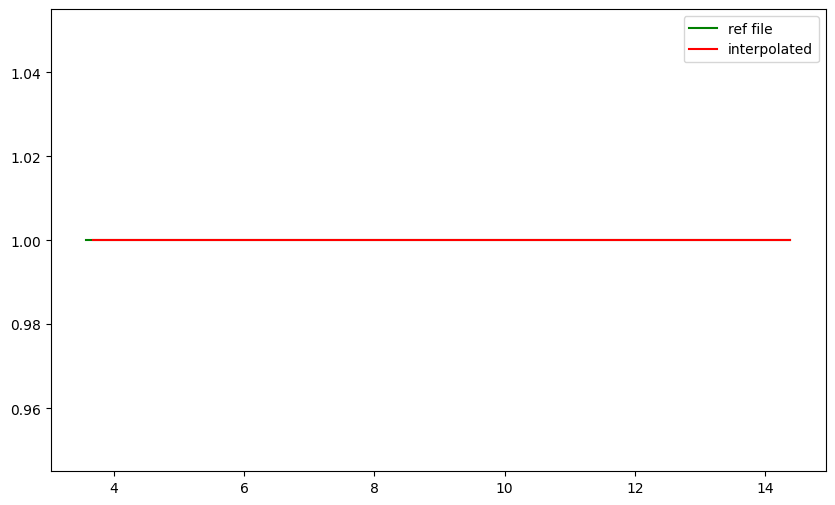

In [12]:
# first identify where the aperture width is in the "size" array
if xwidth >= np.max(acref.apcorr_table[ind]['size']):
    size_ind = np.argwhere(acref.apcorr_table[ind]['size'] == np.max(acref.apcorr_table[ind]['size']))
else:
    size_ind = np.argwhere(acref.apcorr_table[ind]['size'] == xwidth)

# take the vector from the apcorr_table at this location and extract. 
apcorr_vec = acref.apcorr_table[ind]['apcorr'][:,size_ind[0][0]]
print(np.shape(apcorr_vec))
print(np.shape(acref.apcorr_table[ind]['wavelength']))

# now we create an interpolated vector of values corresponding to the lam_vec wavelengths. 
# NOTE: the wavelengths are running in descending order so make sure assume_sorted = FALSE
intp_ac = interp1d(acref.apcorr_table[ind]['wavelength'], apcorr_vec, kind='linear', assume_sorted=False)
iapcorr = intp_ac(lam_vec)


plt.figure(figsize=[10,6])
plt.plot(acref.apcorr_table[1]['wavelength'], apcorr_vec, 'g-', label='ref file')
plt.plot(lam_vec, iapcorr, 'r-', label='interpolated')
#plt.plot(lam_vec, ac_vals, 'r-', label='aperture corrections for {} px ap'.format(xwidth))
plt.legend()
plt.show()

Now multiply the manually extracted spectra by the flux scaling and aperture correction vectors.

In [13]:
# now convert flux from MJy/sr to Jy using the pixel area
if (s1.meta.bunit_data == 'MJy/sr'):
    xsub_cal = xsub * pixar_sr.value * 1e6 * iapcorr

Next we run the ``extract_1d()`` step on the same file, editing the configuration to sum up over the entire aperture as we did above. We load in the json file, make adjustments and run the step with a config file override option.

In [14]:
extreffile='jwst_miri_extract1d_0004.json'
basename=crds.core.config.pop_crds_uri(extreffile)
path=crds.locate_file(basename,"jwst")
with open(path) as json_ref:
    jsreforig = json.load(json_ref)
    jsrefdict = jsreforig.copy()
    jsrefdict['apertures'][0]['xstart'] = int(np.min(x))
    jsrefdict['apertures'][0]['xstop'] = int(np.max(x)) + 1
    #jsrefdict['apertures'][0]['use_source_posn'] = False
    
    for element in jsrefdict['apertures']:
        element.pop('extract_width', None)
        element.pop('nod2_offset', None)

with open('extract1d_slit_full_spec2.json','w') as jsrefout:
    json.dump(jsrefdict,jsrefout,indent=4)

In [15]:
with open('extract1d_slit_full_spec2.cfg','w') as cfg:
    cfg.write('name = "extract_1d"'+'\n')
    cfg.write('class = "jwst.extract_1d.Extract1dStep"'+'\n')
    cfg.write(''+'\n')
    cfg.write('log_increment = 50'+'\n')
    cfg.write('smoothing_length = 0'+'\n')
    cfg.write('use_source_posn = False' + '\n')
    cfg.write('override_extract1d="extract1d_slit_full_spec2.json"'+'\n')

In [16]:
xsub_pipe = Extract1dStep.call(s1, config_file='extract1d_slit_full_spec2.cfg', save_results=True)

2022-10-04 22:44:33,554 - stpipe - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stpipe/config_parser.py:118: ResourceWarning: unclosed file <_io.BufferedReader name='extract1d_slit_full_spec2.cfg'>
  return ConfigObj(config_file, raise_errors=True)



2022-10-04 22:44:33,556 - stpipe.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 22:44:33,679 - stpipe.extract_1d - INFO - Step extract_1d running with args (<SlitModel(387, 44) from miri_lrs_slit_pt_nod1_v2_s2d.fits>,).


2022-10-04 22:44:33,680 - stpipe.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'smoothing_length': 0, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': False, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 22:44:33,727 - stpipe.extract_1d - INFO - Using EXTRACT1D reference file /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmph_aszc_9/extract1d_slit_full_spec2.json


2022-10-04 22:44:33,775 - stpipe.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0007.fits


2022-10-04 22:44:33,820 - stpipe.extract_1d - WARNING - spectral_order is None; using 1


2022-10-04 22:44:33,821 - stpipe.extract_1d - INFO - Processing spectral order 1


2022-10-04 22:44:33,829 - stpipe.extract_1d - INFO - Using extraction limits: xstart=0, xstop=43, ystart=0, ystop=386


2022-10-04 22:44:33,927 - stpipe.extract_1d - INFO - Applying Aperture correction.


2022-10-04 22:44:34,176 - stpipe.extract_1d - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 22:44:34,260 - stpipe.extract_1d - INFO - Saved model in miri_lrs_slit_pt_nod1_v2_extract_1d.fits


2022-10-04 22:44:34,261 - stpipe.extract_1d - INFO - Step extract_1d done


If the step ran successfully, we can now look at the output and compare to our manual extraction spectrum. To ratio the 2 spectra we interpolate the manually extracted spectrum ``xsub_cal`` onto the pipeline-generated wavelength grid. 

2022-10-04 22:44:34,298 - stpipe - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/ipykernel_3953946/3513025096.py:17: RuntimeWarning: invalid value encountered in divide
  diff = ((xsub_pipe.spec[0].spec_table['FLUX'] - ixsub_cal) / xsub_pipe.spec[0].spec_table['FLUX']) * 100.



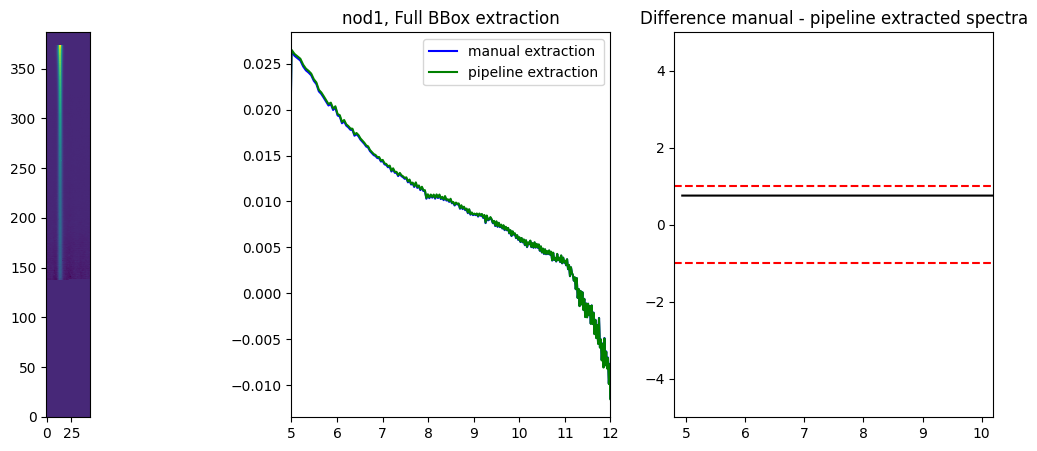

In [17]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=[14,5])
ax[0].imshow(s2d_sub, origin='lower', interpolation='None')
ax[1].plot(lam_vec, xsub_cal, 'b-', label='manual extraction')
ax[1].plot(xsub_pipe.spec[0].spec_table['WAVELENGTH'], xsub_pipe.spec[0].spec_table['FLUX'], 'g-', label='pipeline extraction')
ax[1].set_title('{0}, Full BBox extraction'.format(nn))
ax[1].legend()
ax[1].set_xlim([5, 12])
#ax[1].set_ylim([0.004, 0.008])

#interpolate the two onto the same grid so we can look at the difference
f = interp1d(lam_vec, xsub_cal, kind='linear', fill_value='extrapolate')
ixsub_cal = f(xsub_pipe.spec[0].spec_table['WAVELENGTH'])

#ax[1].plot(xsub_pipe.spec[0].spec_table['WAVELENGTH'], ixsub_cal, 'r-', label='manual, interpolated')


diff = ((xsub_pipe.spec[0].spec_table['FLUX'] - ixsub_cal) / xsub_pipe.spec[0].spec_table['FLUX']) * 100.

ax[2].plot(xsub_pipe.spec[0].spec_table['WAVELENGTH'], diff, 'k-')
ax[2].axhline(y=1., xmin=0, xmax=1, color='r', ls='--')
ax[2].axhline(y=-1., xmin=0, xmax=1, color='r', ls='--')
ax[2].set_title('Difference manual - pipeline extracted spectra')
ax[2].set_ylim([-5., 5.])
ax[2].set_xlim([4.8, 10.2])

fig.show()

We check that the ratio between the 2 is on average <= 1 per cent in the core range between 5 and 10 micron.

In [18]:
inds = (xsub_pipe.spec[0].spec_table['WAVELENGTH'] >= 5.0) & (xsub_pipe.spec[0].spec_table['WAVELENGTH'] <= 10.)
print('Mean difference between pipeline and manual extraction = {:.4f} per cent'.format(np.mean(diff[inds])))
try:
    assert np.mean(diff[inds]) <= 1.0, "Mean difference between pipeline and manual extraction >= 1 per cent in 5-10 um. CHECK."
except AssertionError as e:
    print("****************************************************")
    print("")
    print("ERROR: {}".format(e))
    print("")
    print("****************************************************")

Mean difference between pipeline and manual extraction = 0.7583 per cent


------------------------------**END OF TEST PART 1**----------------------------------------------

#### Test 2: Nodded observation, two exposures

In this second test we use both nodded observations. In this scenarion, the nods are used as each other's background observations and we need to ensure that the extraction aperture is placed in the right position with a realistic aperture for both nods.

We will re-run the first steps of the Spec2Pipeline, so that the nods are used as each other's backgrounds. This requires creation of an association from which the Spec2Pipeline will be run. Then we will run them both through the extract_1d() step with the default parameters, checking:
* the location of the aperture
* the extraction width





In [19]:
asn_files = [det1[0].meta.filename, det1[1].meta.filename]
asn = asn_from_list(asn_files, rule=DMSLevel2bBase, meta={'program':'test', 'target':'bd60', 'asn_pool':'test'})

# now add the opposite nod as background exposure:
asn['products'][0]['members'].append({'expname': 'miri_lrs_slit_pt_nod2_v2.3_rate.fits', 'exptype':'background'})
asn['products'][1]['members'].append({'expname': 'miri_lrs_slit_pt_nod1_v2.3_rate.fits', 'exptype':'background'})

# write this out to a json file
with open('lrs-slit-test_asn.json', 'w') as fp:
    fp.write(asn.dump()[1])

Now run the Spec2Pipeline with this association files as input, instead of the individual FITS files or datamodels.

In [20]:
sp2 = Spec2Pipeline.call('lrs-slit-test_asn.json', save_results=True)

2022-10-04 22:44:34,615 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /grp/crds/cache/references/jwst/jwst_miri_pars-spec2pipeline_0003.asdf


2022-10-04 22:44:34,636 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2022-10-04 22:44:34,637 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-10-04 22:44:34,639 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-10-04 22:44:34,640 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2022-10-04 22:44:34,640 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2022-10-04 22:44:34,642 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2022-10-04 22:44:34,644 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2022-10-04 22:44:34,645 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 22:44:34,646 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2022-10-04 22:44:34,647 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2022-10-04 22:44:34,648 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2022-10-04 22:44:34,649 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2022-10-04 22:44:34,650 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-10-04 22:44:34,651 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2022-10-04 22:44:34,653 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2022-10-04 22:44:34,654 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2022-10-04 22:44:34,655 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2022-10-04 22:44:34,656 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2022-10-04 22:44:34,657 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2022-10-04 22:44:34,658 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2022-10-04 22:44:34,659 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2022-10-04 22:44:34,661 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2022-10-04 22:44:34,662 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2022-10-04 22:44:34,789 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('lrs-slit-test_asn.json',).


2022-10-04 22:44:34,803 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'save_wfss_esec': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix'

2022-10-04 22:44:34,854 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'miri_lrs_slit_pt_nod1_v2.3_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap', 'wfssbkg']


2022-10-04 22:44:34,860 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_miri_apcorr_0007.fits'.


2022-10-04 22:44:34,861 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.


2022-10-04 22:44:34,861 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.


2022-10-04 22:44:34,862 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-10-04 22:44:34,862 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-10-04 22:44:34,862 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.


2022-10-04 22:44:34,863 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-10-04 22:44:34,863 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-10-04 22:44:34,863 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-10-04 22:44:34,864 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-10-04 22:44:34,866 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/grp/crds/cache/references/jwst/jwst_miri_extract1d_0004.json'.


2022-10-04 22:44:34,867 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-10-04 22:44:34,867 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2022-10-04 22:44:34,867 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0736.fits'.


2022-10-04 22:44:34,868 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-10-04 22:44:34,868 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-10-04 22:44:34,869 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2022-10-04 22:44:34,869 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-10-04 22:44:34,869 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-10-04 22:44:34,870 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-10-04 22:44:34,870 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2022-10-04 22:44:34,870 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-10-04 22:44:34,870 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is 'N/A'.


2022-10-04 22:44:34,871 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-10-04 22:44:34,871 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/grp/crds/cache/references/jwst/jwst_miri_pathloss_0001.fits'.


2022-10-04 22:44:34,872 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0072.fits'.


2022-10-04 22:44:34,873 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-10-04 22:44:34,874 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-10-04 22:44:34,874 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2022-10-04 22:44:34,874 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2022-10-04 22:44:34,874 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECTRACE reference file is 'N/A'.


2022-10-04 22:44:34,875 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0003.fits'.


2022-10-04 22:44:34,876 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is 'N/A'.


2022-10-04 22:44:34,876 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-10-04 22:44:34,876 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVEMAP reference file is 'N/A'.


2022-10-04 22:44:34,877 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-10-04 22:44:34,877 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2022-10-04 22:44:34,884 - stpipe.Spec2Pipeline - INFO - Processing product miri_lrs_slit_pt_nod1_v2.3


2022-10-04 22:44:34,885 - stpipe.Spec2Pipeline - INFO - Working on input miri_lrs_slit_pt_nod1_v2.3_rate.fits ...


2022-10-04 22:44:35,036 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-10-04 22:44:35,037 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 22:44:35,298 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_lrs-fixedslit pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0003.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 22:44:35,394 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.000379612 -0.000035778 0.000379612 0.000080412 359.999082432 0.000080412 359.999082432 -0.000035778


2022-10-04 22:44:35,395 - stpipe.Spec2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.000379612 -0.000035778 0.000379612 0.000080412 359.999082432 0.000080412 359.999082432 -0.000035778


2022-10-04 22:44:35,396 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 22:44:35,409 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 22:44:35,536 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>, ['miri_lrs_slit_pt_nod2_v2.3_rate.fits']).


2022-10-04 22:44:35,538 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 22:44:35,544 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Accumulate bkg from miri_lrs_slit_pt_nod2_v2.3_rate.fits


2022-10-04 22:44:35,840 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 22:44:35,968 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>, []).


2022-10-04 22:44:35,970 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 22:44:35,970 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 22:44:35,973 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 22:44:36,090 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-10-04 22:44:36,091 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 22:44:36,091 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 22:44:36,094 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 22:44:36,210 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-10-04 22:44:36,211 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 22:44:36,219 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_LRS-FIXEDSLIT


2022-10-04 22:44:36,219 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 22:44:36,220 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 22:44:36,220 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = POINT


2022-10-04 22:44:36,224 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 22:44:36,347 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-10-04 22:44:36,348 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 22:44:36,412 - stpipe.Spec2Pipeline.flat_field - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stdatamodels/validate.py:38: ValidationWarning: While validating meta.exposure.type the following error occurred:
'MIR_FLAT-IMAGE' is not one of ['FGS_DARK', 'FGS_FOCUS', 'FGS_IMAGE', 'FGS_INTFLAT', 'FGS_SKYFLAT', 'FGS_ACQ1', 'FGS_ACQ2', 'FGS_FINEGUIDE', 'FGS_ID-IMAGE', 'FGS_ID-STACK', 'FGS_TRACK', 'MIR_4QPM', 'MIR_CORONCAL', 'MIR_DARKALL', 'MIR_DARKIMG', 'MIR_DARKMRS', 'MIR_FLATIMAGE', 'MIR_FLATIMAGE-EXT', 'MIR_FLATMRS', 'MIR_FLATMRS-EXT', 'MIR_IMAGE', 'MIR_LRS-FIXEDSLIT', 'MIR_LRS-SLITLESS', 'MIR_LYOT', 'MIR_MRS', 'MIR_TACONFIRM', 'MIR_TACQ', 'NIS_AMI', 'NIS_DARK', 'NIS_EXTCAL', 'NIS_FOCUS', 'NIS_IMAGE', 'NIS_LAMP', 'NIS_SOSS', 'NIS_TACQ', 'NIS_TACONFIRM', 'NIS_WFSS', 'NRC_CORON', 'NRC_DARK', 'NRC_FLAT', 'NRC_FOCUS', 'NRC_GRISM', 'NRC_IMAGE', 'NRC_WFSS', 'NRC_LED

2022-10-04 22:44:36,462 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 22:44:36,463 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 22:44:36,463 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 22:44:36,483 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 22:44:36,662 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 22:44:36,791 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-10-04 22:44:36,792 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 22:44:36,793 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 22:44:36,796 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 22:44:36,920 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-10-04 22:44:36,922 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-10-04 22:44:36,923 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2022-10-04 22:44:36,925 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 22:44:37,044 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-10-04 22:44:37,046 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 22:44:37,061 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /grp/crds/cache/references/jwst/jwst_miri_pathloss_0001.fits


2022-10-04 22:44:37,100 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is MIR_LRS-FIXEDSLIT


2022-10-04 22:44:37,320 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 22:44:37,451 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-10-04 22:44:37,452 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 22:44:37,453 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 22:44:37,455 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 22:44:37,572 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2.3_rate.fits>,).


2022-10-04 22:44:37,573 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 22:44:37,596 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0072.fits


2022-10-04 22:44:37,596 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 22:44:37,701 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 22:44:37,702 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-10-04 22:44:37,702 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_LRS-FIXEDSLIT


2022-10-04 22:44:37,703 - stpipe.Spec2Pipeline.photom - INFO -  filter: P750L


2022-10-04 22:44:37,729 - stpipe.Spec2Pipeline.photom - INFO -  subarray: FULL


2022-10-04 22:44:37,730 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 60.567


2022-10-04 22:44:37,786 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 22:44:37,919 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod1_v2_cal.fits>,).


2022-10-04 22:44:37,920 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}


2022-10-04 22:44:38,162 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-10-04 22:44:38,288 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter kernal: square


2022-10-04 22:44:38,289 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter pixfrac: 1.0


2022-10-04 22:44:38,289 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter fillval: INDEF


2022-10-04 22:44:38,290 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter weight_type: ivm


2022-10-04 22:44:38,331 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data


2022-10-04 22:44:39,047 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)


2022-10-04 22:44:39,062 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise


2022-10-04 22:44:39,799 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)


2022-10-04 22:44:39,807 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson


2022-10-04 22:44:40,523 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)


2022-10-04 22:44:40,531 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat


2022-10-04 22:44:41,240 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)


2022-10-04 22:44:41,265 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  359.999103211 -0.000033657 0.000420119 -0.000033657 0.000420119 0.000075807 359.999103211 0.000075807


2022-10-04 22:44:41,374 - stpipe.Spec2Pipeline.resample_spec - INFO - Saved model in miri_lrs_slit_pt_nod1_v2_s2d.fits


2022-10-04 22:44:41,375 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done


2022-10-04 22:44:41,536 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(387, 44) from miri_lrs_slit_pt_nod1_v2_s2d.fits>,).


2022-10-04 22:44:41,538 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 22:44:41,632 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0004.json


2022-10-04 22:44:41,680 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0007.fits


2022-10-04 22:44:41,720 - stpipe.Spec2Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_LRS-FIXEDSLIT


2022-10-04 22:44:41,721 - stpipe.Spec2Pipeline.extract_1d - WARNING - spectral_order is None; using 1


2022-10-04 22:44:41,721 - stpipe.Spec2Pipeline.extract_1d - INFO - Processing spectral order 1


2022-10-04 22:44:41,731 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying position offset of -7.78 to xstart and xstop


2022-10-04 22:44:41,732 - stpipe.Spec2Pipeline.extract_1d - INFO - Using extraction limits: xstart=8.717824039833275, xstop=18.717824039833275, ystart=0, ystop=386


2022-10-04 22:44:41,826 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.


2022-10-04 22:44:42,145 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in miri_lrs_slit_pt_nod1_v2_x1d.fits


2022-10-04 22:44:42,146 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 22:44:42,146 - stpipe.Spec2Pipeline - INFO - Finished processing product miri_lrs_slit_pt_nod1_v2.3


2022-10-04 22:44:42,147 - stpipe.Spec2Pipeline - INFO - Processing product miri_lrs_slit_pt_nod2_v2.3


2022-10-04 22:44:42,147 - stpipe.Spec2Pipeline - INFO - Working on input miri_lrs_slit_pt_nod2_v2.3_rate.fits ...


2022-10-04 22:44:42,313 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-10-04 22:44:42,314 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-10-04 22:44:42,569 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a MIRI mir_lrs-fixedslit pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': None, 'specwcs': '/grp/crds/cache/references/jwst/jwst_miri_specwcs_0003.fits', 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-10-04 22:44:42,669 - stpipe.Spec2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.000903013 -0.000079284 0.000903013 0.000036907 359.999605833 0.000036907 359.999605833 -0.000079284


2022-10-04 22:44:42,670 - stpipe.Spec2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.000903013 -0.000079284 0.000903013 0.000036907 359.999605833 0.000036907 359.999605833 -0.000079284


2022-10-04 22:44:42,671 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-10-04 22:44:42,684 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-10-04 22:44:42,813 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>, ['miri_lrs_slit_pt_nod1_v2.3_rate.fits']).


2022-10-04 22:44:42,815 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}


2022-10-04 22:44:42,822 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Accumulate bkg from miri_lrs_slit_pt_nod1_v2.3_rate.fits


2022-10-04 22:44:43,110 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2022-10-04 22:44:43,249 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>, []).


2022-10-04 22:44:43,250 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': ''}


2022-10-04 22:44:43,251 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2022-10-04 22:44:43,253 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done


2022-10-04 22:44:43,373 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-10-04 22:44:43,375 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'msa_flagging', 'search_output_file': True, 'input_dir': ''}


2022-10-04 22:44:43,376 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step skipped.


2022-10-04 22:44:43,378 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2022-10-04 22:44:43,502 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-10-04 22:44:43,504 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'srctype', 'search_output_file': True, 'input_dir': '', 'source_type': None}


2022-10-04 22:44:43,511 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_LRS-FIXEDSLIT


2022-10-04 22:44:43,511 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = None


2022-10-04 22:44:43,511 - stpipe.Spec2Pipeline.srctype - WARNING - SRCTYAPT keyword not found in input; using SRCTYPE instead


2022-10-04 22:44:43,512 - stpipe.Spec2Pipeline.srctype - INFO - Input source type is unknown; setting default SRCTYPE = POINT


2022-10-04 22:44:43,515 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2022-10-04 22:44:43,635 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-10-04 22:44:43,637 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-10-04 22:44:43,701 - stpipe.Spec2Pipeline.flat_field - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.9/site-packages/stdatamodels/validate.py:38: ValidationWarning: While validating meta.exposure.type the following error occurred:
'MIR_FLAT-IMAGE' is not one of ['FGS_DARK', 'FGS_FOCUS', 'FGS_IMAGE', 'FGS_INTFLAT', 'FGS_SKYFLAT', 'FGS_ACQ1', 'FGS_ACQ2', 'FGS_FINEGUIDE', 'FGS_ID-IMAGE', 'FGS_ID-STACK', 'FGS_TRACK', 'MIR_4QPM', 'MIR_CORONCAL', 'MIR_DARKALL', 'MIR_DARKIMG', 'MIR_DARKMRS', 'MIR_FLATIMAGE', 'MIR_FLATIMAGE-EXT', 'MIR_FLATMRS', 'MIR_FLATMRS-EXT', 'MIR_IMAGE', 'MIR_LRS-FIXEDSLIT', 'MIR_LRS-SLITLESS', 'MIR_LYOT', 'MIR_MRS', 'MIR_TACONFIRM', 'MIR_TACQ', 'NIS_AMI', 'NIS_DARK', 'NIS_EXTCAL', 'NIS_FOCUS', 'NIS_IMAGE', 'NIS_LAMP', 'NIS_SOSS', 'NIS_TACQ', 'NIS_TACONFIRM', 'NIS_WFSS', 'NRC_CORON', 'NRC_DARK', 'NRC_FLAT', 'NRC_FOCUS', 'NRC_GRISM', 'NRC_IMAGE', 'NRC_WFSS', 'NRC_LED

2022-10-04 22:44:43,751 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 22:44:43,752 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 22:44:43,752 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 22:44:43,771 - stpipe.Spec2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-10-04 22:44:43,949 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2022-10-04 22:44:44,080 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-10-04 22:44:44,082 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'straylight', 'search_output_file': True, 'input_dir': ''}


2022-10-04 22:44:44,082 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.


2022-10-04 22:44:44,085 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done


2022-10-04 22:44:44,208 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-10-04 22:44:44,210 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'fringe', 'search_output_file': True, 'input_dir': ''}


2022-10-04 22:44:44,211 - stpipe.Spec2Pipeline.fringe - INFO - Step skipped.


2022-10-04 22:44:44,213 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe done


2022-10-04 22:44:44,347 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-10-04 22:44:44,348 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'pathloss', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 22:44:44,365 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /grp/crds/cache/references/jwst/jwst_miri_pathloss_0001.fits


2022-10-04 22:44:44,405 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is MIR_LRS-FIXEDSLIT


2022-10-04 22:44:44,621 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2022-10-04 22:44:44,761 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-10-04 22:44:44,763 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'barshadow', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 22:44:44,763 - stpipe.Spec2Pipeline.barshadow - INFO - Step skipped.


2022-10-04 22:44:44,766 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2022-10-04 22:44:44,890 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2.3_rate.fits>,).


2022-10-04 22:44:44,891 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-10-04 22:44:44,915 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0072.fits


2022-10-04 22:44:44,915 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: N/A


2022-10-04 22:44:45,024 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: MIRI


2022-10-04 22:44:45,024 - stpipe.Spec2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-10-04 22:44:45,025 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: MIR_LRS-FIXEDSLIT


2022-10-04 22:44:45,025 - stpipe.Spec2Pipeline.photom - INFO -  filter: P750L


2022-10-04 22:44:45,054 - stpipe.Spec2Pipeline.photom - INFO -  subarray: FULL


2022-10-04 22:44:45,055 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 60.567


2022-10-04 22:44:45,114 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2022-10-04 22:44:45,256 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<ImageModel(1024, 1032) from miri_lrs_slit_pt_nod2_v2_cal.fits>,).


2022-10-04 22:44:45,258 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': False, 'allowed_memory': None, 'in_memory': True}


2022-10-04 22:44:45,498 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-10-04 22:44:45,623 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter kernal: square


2022-10-04 22:44:45,624 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter pixfrac: 1.0


2022-10-04 22:44:45,624 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter fillval: INDEF


2022-10-04 22:44:45,624 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter weight_type: ivm


2022-10-04 22:44:45,666 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data


2022-10-04 22:44:46,385 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)


2022-10-04 22:44:46,400 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise


2022-10-04 22:44:47,097 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)


2022-10-04 22:44:47,106 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson


2022-10-04 22:44:47,824 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)


2022-10-04 22:44:47,832 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat


2022-10-04 22:44:48,549 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (1024, 1032) --> (387, 44)


2022-10-04 22:44:48,574 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  359.999626612 -0.000077162 0.000943519 -0.000077162 0.000943519 0.000032302 359.999626612 0.000032302


2022-10-04 22:44:48,684 - stpipe.Spec2Pipeline.resample_spec - INFO - Saved model in miri_lrs_slit_pt_nod2_v2_s2d.fits


2022-10-04 22:44:48,685 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done


2022-10-04 22:44:48,848 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(387, 44) from miri_lrs_slit_pt_nod2_v2_s2d.fits>,).


2022-10-04 22:44:48,850 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': '', 'smoothing_length': None, 'bkg_fit': None, 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}


2022-10-04 22:44:48,947 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /grp/crds/cache/references/jwst/jwst_miri_extract1d_0004.json


2022-10-04 22:44:48,996 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0007.fits


2022-10-04 22:44:49,037 - stpipe.Spec2Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = MIR_LRS-FIXEDSLIT


2022-10-04 22:44:49,038 - stpipe.Spec2Pipeline.extract_1d - WARNING - spectral_order is None; using 1


2022-10-04 22:44:49,038 - stpipe.Spec2Pipeline.extract_1d - INFO - Processing spectral order 1


2022-10-04 22:44:49,049 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying position offset of 9.31 to xstart and xstop


2022-10-04 22:44:49,049 - stpipe.Spec2Pipeline.extract_1d - INFO - Using extraction limits: xstart=25.80802957362824, xstop=35.80802957362824, ystart=0, ystop=386


2022-10-04 22:44:49,145 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.


2022-10-04 22:44:49,466 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in miri_lrs_slit_pt_nod2_v2_x1d.fits


2022-10-04 22:44:49,467 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2022-10-04 22:44:49,467 - stpipe.Spec2Pipeline - INFO - Finished processing product miri_lrs_slit_pt_nod2_v2.3


2022-10-04 22:44:49,468 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2022-10-04 22:44:49,468 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 22:44:49,468 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_0988.pmap


2022-10-04 22:44:49,669 - stpipe.Spec2Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod1_v2_cal.fits


2022-10-04 22:44:49,869 - stpipe.Spec2Pipeline - INFO - Saved model in miri_lrs_slit_pt_nod2_v2_cal.fits


2022-10-04 22:44:49,870 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


['miri_lrs_slit_pt_nod1_v2_x1d.fits', 'miri_lrs_slit_pt_nod2_v2_x1d.fits']


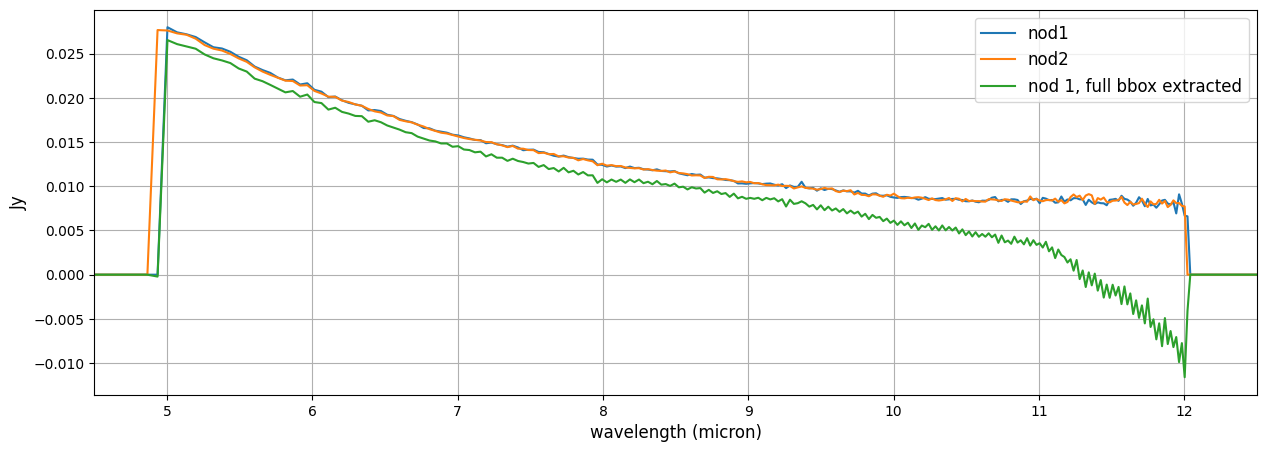

In [21]:
x1dfiles = glob('*_x1d.fits')
print(x1dfiles)
x1ds = [datamodels.open(xf) for xf in x1dfiles]
fig = plt.figure(figsize=[15,5])

for x1 in x1ds:
    if 'nod1' in x1.meta.filename:
        nn = 'nod1'
    else: 
        nn = 'nod2'
    plt.plot(x1.spec[0].spec_table['WAVELENGTH'], x1.spec[0].spec_table['FLUX'], label=nn)

plt.plot(xsub_pipe.spec[0].spec_table['WAVELENGTH'], xsub_pipe.spec[0].spec_table['FLUX'], label='nod 1, full bbox extracted')
plt.legend(fontsize='large')
plt.grid()
plt.xlim([4.5, 12.5])
plt.xlabel('wavelength (micron)', fontsize='large')
plt.ylabel('Jy', fontsize='large')
fig.show()

What we will test for:
* the extracted spectra should be near-identical (chosen criteria: mean ration between the 2 <= 5%)


**Further tests to add:**
* perform a full verification of the extraction at the source position and with the same extraction width as in the parameters file.

**If the ``assert`` statement below passes, we consider the test a success.**



In [22]:
inds = x1ds[0].spec[0].spec_table['FLUX'] > 0.00
ratio = x1ds[0].spec[0].spec_table['FLUX'][inds] / x1ds[1].spec[0].spec_table['FLUX'][inds]
infs = np.isinf(ratio-1.0)

try:
    assert np.mean(np.abs(ratio[~infs] - 1.)) <= 0.05, "Extracted spectra don't match! CHECK!"
except AssertionError as e:
    print("****************************************************")
    print("")
    print("ERROR: {}".format(e))
    print("")
    print("****************************************************")

2022-10-04 22:44:50,156 - stpipe - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/ipykernel_3953946/2475629123.py:2: RuntimeWarning: divide by zero encountered in divide
  ratio = x1ds[0].spec[0].spec_table['FLUX'][inds] / x1ds[1].spec[0].spec_table['FLUX'][inds]



* Authors: B. Sargent/S. Kendrew, MIRI branch
* Last updated: March 24th 2021 (S. Kendrew)